In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import func

from database.model.activity import Activity
from database.model.sensor_record import SensorRecord
from database.model.session import Session
from database.tools import my_conn

In [5]:
db = my_conn.load_db()

sensor_data_count = (
    db.query(Session.subject_id, func.count("*"))
    .join(SensorRecord)
    .group_by(Session.subject_id)
    .order_by(Session.subject_id)
    .all()
)

df = pd.DataFrame(sensor_data_count, columns=["Subject_ID", "SensorData_Count"])
total_count = df["SensorData_Count"].sum()
total_df = pd.DataFrame([{"Subject_ID": "Total", "SensorData_Count": total_count}])
df = pd.concat([df, total_df])
print(df.to_string(index=False))

Subject_ID  SensorData_Count
         1             35174
         2             35532
         3             35380
         4             35328
         5             33947
         6             32205
         7             34253
         8             33332
         9             34354
        10             33690
     Total            343195


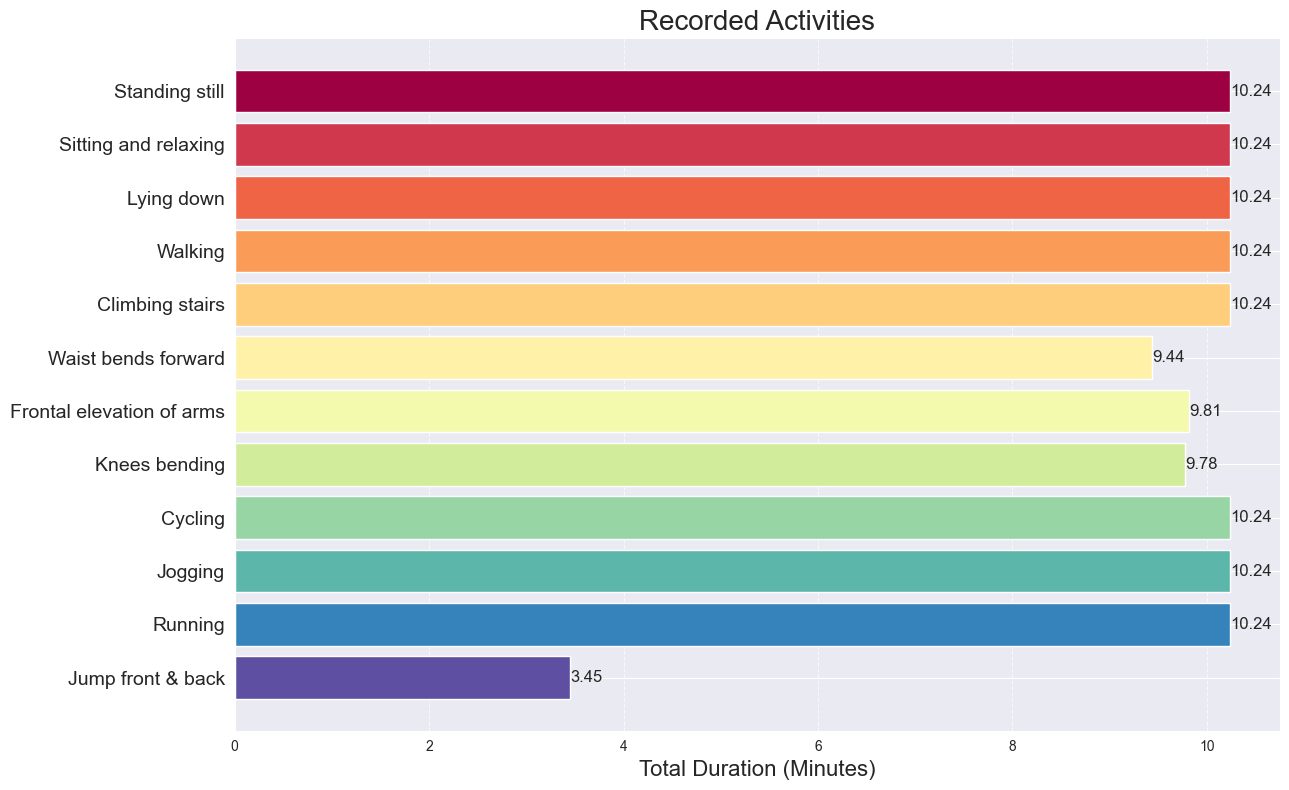

In [6]:
activity_count = (
    db.query(Activity.description, func.count(SensorRecord.sequence))
    .join(Session, Session.id == SensorRecord.session_id)
    .join(Activity, Activity.id == Session.activity_id)
    .group_by(Activity.description, Activity.id)
    .order_by(Activity.id)
    .all()
)
db.close()

df = pd.DataFrame(activity_count, columns=["Activity", "Count"])
df["Duration"] = df["Count"] / 50 / 60

plt.figure(figsize=(13, 8))
colors = plt.get_cmap("Spectral")(np.linspace(0, 1, 10))
plt.barh(
    df["Activity"],
    df["Duration"],
    color=plt.colormaps["Spectral"](np.linspace(0, 1, len(df))),
)

plt.title("Recorded Activities", fontsize=20)
plt.xlabel("Total Duration (Minutes)", fontsize=16)
plt.yticks(fontsize=14)
for i, v in enumerate(df["Duration"]):
    plt.text(v, i, f"{v:.2f}", va="center", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

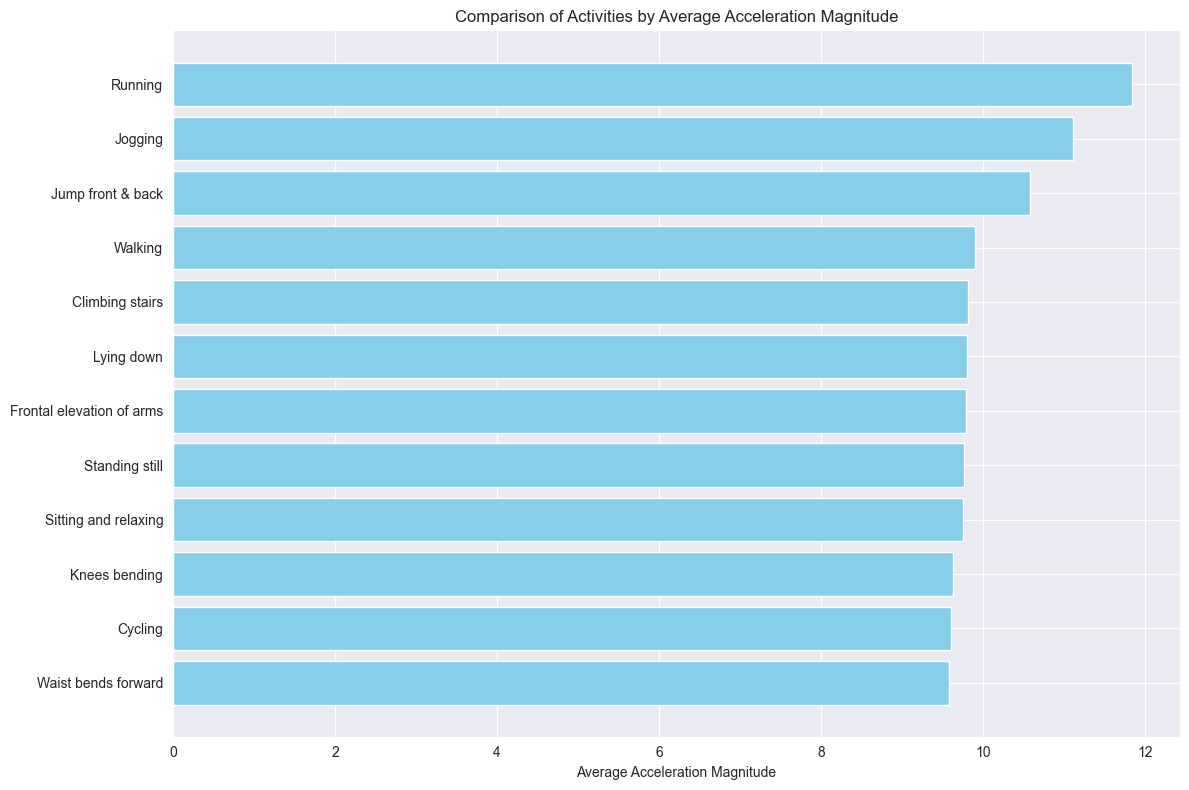

In [7]:
activity_sensor_stats = (
    db.query(
        Activity.description,
        func.avg(
            func.sqrt(
                func.pow(SensorRecord.acceleration_chest_x, 2)
                + func.pow(SensorRecord.acceleration_chest_y, 2)
                + func.pow(SensorRecord.acceleration_chest_z, 2)
            )
        ).label("avg_acceleration_magnitude"),
    )
    .join(Session, Session.id == SensorRecord.session_id)
    .join(Activity, Activity.id == Session.activity_id)
    .group_by(Activity.description)
    .all()
)
db.close()

df_activity_stats = pd.DataFrame(
    activity_sensor_stats, columns=["Activity", "Average Acceleration Magnitude"]
)
df_activity_stats = df_activity_stats.sort_values(
    "Average Acceleration Magnitude", ascending=True
)

plt.figure(figsize=(12, 8))
plt.barh(
    df_activity_stats["Activity"],
    df_activity_stats["Average Acceleration Magnitude"],
    color="skyblue",
)
plt.xlabel("Average Acceleration Magnitude")
plt.title("Comparison of Activities by Average Acceleration Magnitude")
plt.tight_layout()
plt.show()

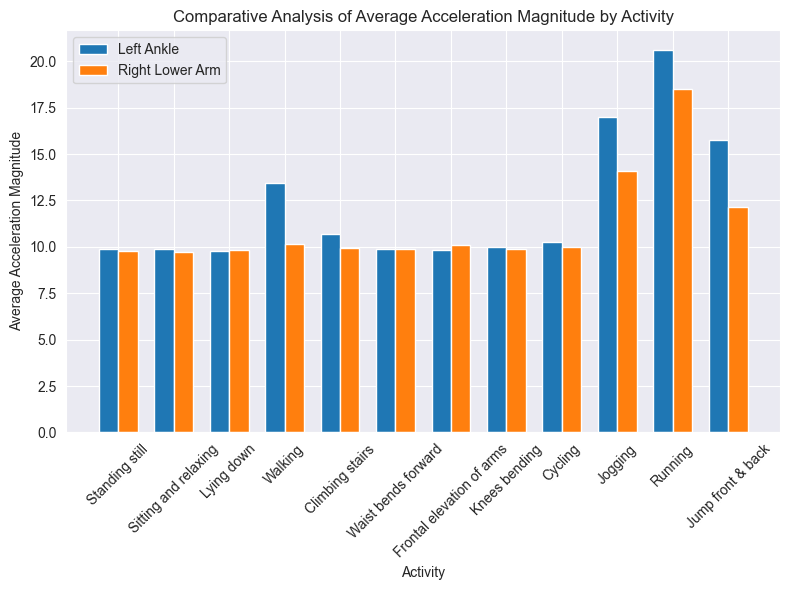

In [8]:
query = (
    db.query(
        Activity.description,
        func.avg(
            func.sqrt(
                func.pow(SensorRecord.acceleration_left_ankle_x, 2)
                + func.pow(SensorRecord.acceleration_left_ankle_y, 2)
                + func.pow(SensorRecord.acceleration_left_ankle_z, 2)
            )
        ),
        func.avg(
            func.sqrt(
                func.pow(SensorRecord.acceleration_right_lower_arm_x, 2)
                + func.pow(SensorRecord.acceleration_right_lower_arm_y, 2)
                + func.pow(SensorRecord.acceleration_right_lower_arm_z, 2)
            )
        ),
    )
    .join(Session, Session.id == SensorRecord.session_id)
    .join(Activity, Activity.id == Session.activity_id)
    .group_by(Activity.id)
    .order_by(Activity.id)
    .all()
)

db.close()

df_activity_stats = pd.DataFrame(
    query,
    columns=[
        "Activity",
        "Avg Acceleration Left Ankle",
        "Avg Acceleration Right Lower Arm",
    ],
)

plt.figure(figsize=(8, 6))
bar_width = 0.35
index = np.arange(len(df_activity_stats["Activity"]))

plt.bar(
    index,
    df_activity_stats["Avg Acceleration Left Ankle"],
    bar_width,
    label="Left Ankle",
)
plt.bar(
    index + bar_width,
    df_activity_stats["Avg Acceleration Right Lower Arm"],
    bar_width,
    label="Right Lower Arm",
)

plt.xlabel("Activity")
plt.ylabel("Average Acceleration Magnitude")
plt.title("Comparative Analysis of Average Acceleration Magnitude by Activity")
plt.xticks(index + bar_width / 2, df_activity_stats["Activity"], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

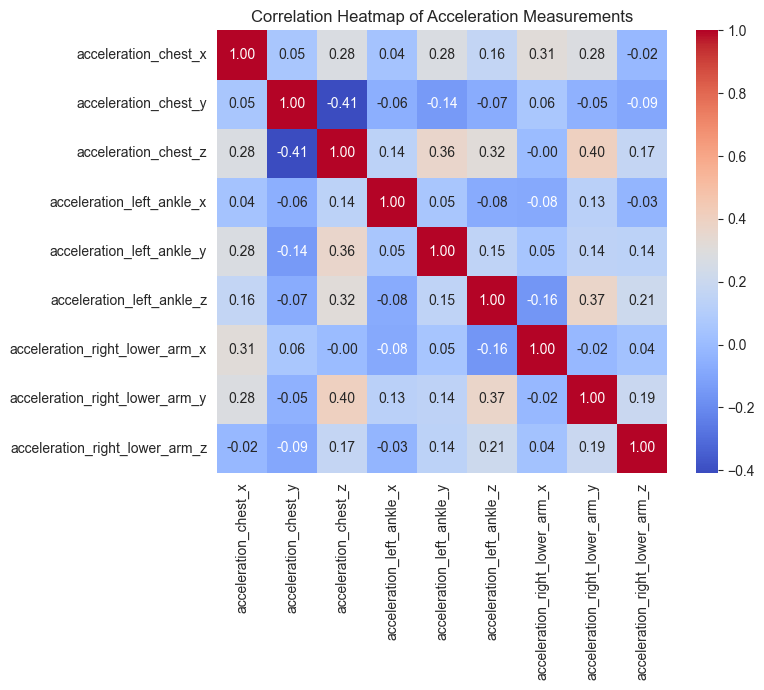

In [9]:
sensor_data_query = db.query(
    SensorRecord.acceleration_chest_x,
    SensorRecord.acceleration_chest_y,
    SensorRecord.acceleration_chest_z,
    SensorRecord.acceleration_left_ankle_x,
    SensorRecord.acceleration_left_ankle_y,
    SensorRecord.acceleration_left_ankle_z,
    SensorRecord.acceleration_right_lower_arm_x,
    SensorRecord.acceleration_right_lower_arm_y,
    SensorRecord.acceleration_right_lower_arm_z,
).all()
db.close()

df_sensor_data = pd.DataFrame(sensor_data_query)
corr_matrix = df_sensor_data.corr()

plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Acceleration Measurements")
plt.tight_layout()
plt.show()

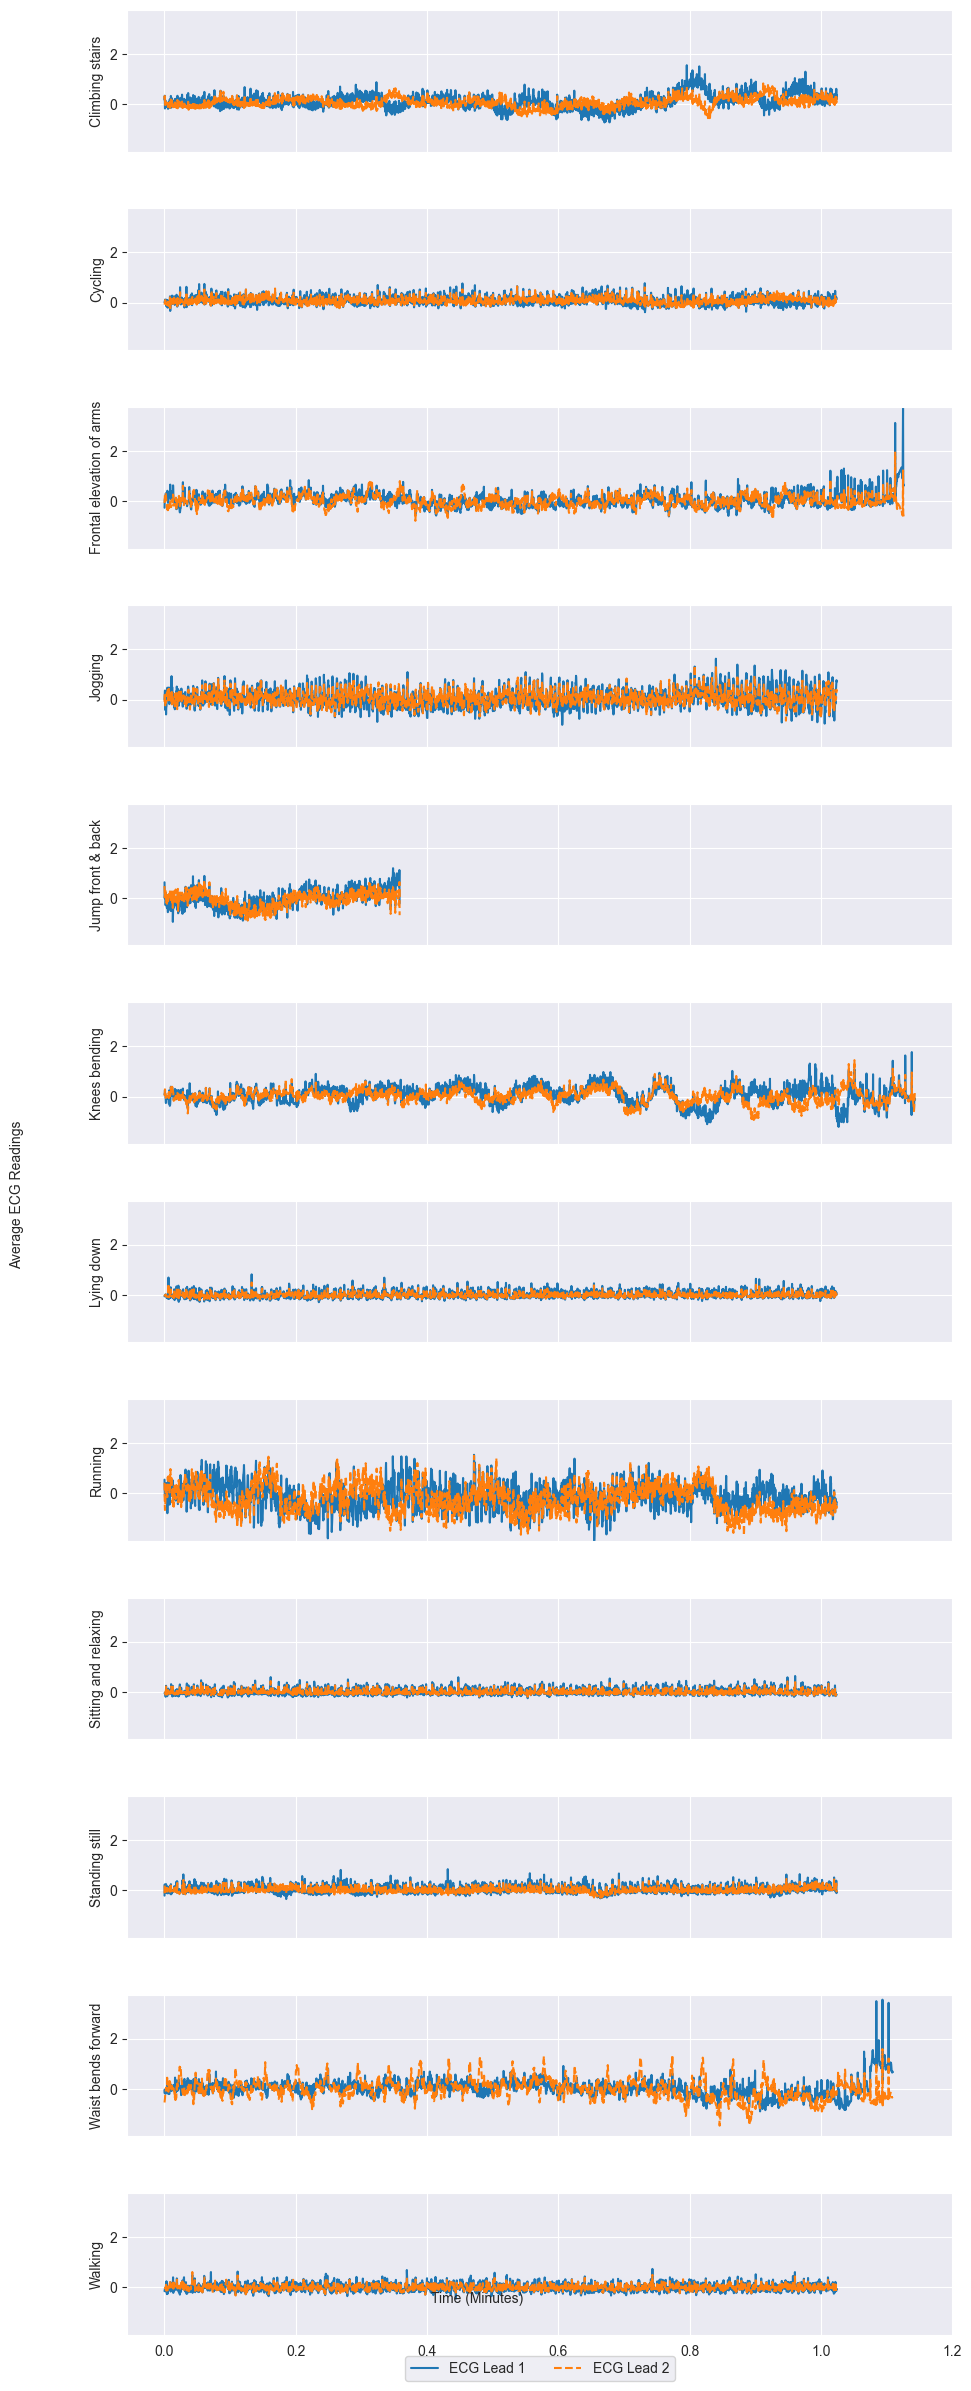

In [13]:
activity_ecg_data = (
    db.query(
        Activity.description.label("activity"),
        (SensorRecord.sequence / (50 * 60)).label("minute"),
        func.avg(SensorRecord.ecg_lead_1).label("avg_ecg_lead_1"),
        func.avg(SensorRecord.ecg_lead_2).label("avg_ecg_lead_2"),
    )
    .join(Session, Session.id == SensorRecord.session_id)
    .join(Activity, Activity.id == Session.activity_id)
    .where()
    .group_by("activity", "minute")
    .order_by("activity", "minute")
    .all()
)

df = pd.DataFrame(
    activity_ecg_data, columns=["Activity", "Minute", "AvgECG1", "AvgECG2"]
)

df_pivot_ecg1 = df.pivot(index="Activity", columns="Minute", values="AvgECG1")
df_pivot_ecg2 = df.pivot(index="Activity", columns="Minute", values="AvgECG2")

global_min_ecg = min(df_pivot_ecg1.min().min(), df_pivot_ecg2.min().min())
global_max_ecg = max(df_pivot_ecg1.max().max(), df_pivot_ecg2.max().max())

activities = df_pivot_ecg1.index
n_activities = len(activities)

fig, axes = plt.subplots(n_activities, 1, figsize=(10, 2 * n_activities), sharex=True)

for i, activity in enumerate(activities):
    axes[i].plot(df_pivot_ecg1.columns, df_pivot_ecg1.loc[activity], label="ECG Lead 1")
    axes[i].plot(
        df_pivot_ecg2.columns,
        df_pivot_ecg2.loc[activity],
        label="ECG Lead 2",
        linestyle="--",
    )
    axes[i].set_ylabel(activity, fontsize=10)
    axes[i].set_ylim(global_min_ecg, global_max_ecg)
    axes[i].yaxis.set_label_position("left")
    axes[i].yaxis.tick_left()

axes[-1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

fig.text(0.5, 0.04, "Time (Minutes)", ha="center", va="center")
fig.text(
    0.04, 0.5, "Average ECG Readings", ha="center", va="center", rotation="vertical"
)

plt.tight_layout()
plt.subplots_adjust(left=0.15, hspace=0.4)

plt.show()